## MERGING BOTH DATASETS

In [1]:
from os import listdir
from os.path import isfile, join

import re
from itertools import combinations
from itertools import chain

import pandas as pd
import numpy as np

import geopandas as gpd
import geojson
import rtree

import folium.folium

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins

%matplotlib inline

pd.set_option('display.max_rows', 1000)
sns.set_style("darkgrid", {"axes.facecolor": ".8"})

## DEF AND GLOBAL VARIABLES

In [2]:
# GLOBAL variables
CLEAN_PATH = '../data/clean' # transform this into temp file
MODEL_PATH = '../data/modelbase'

NAMES_DICT = {
    
    'build_gdf': 'bu_point',
    'arturo_gdf': 'qlity_mdl',
}

MADRID_EPSG = 25830
STATE = 42

In [3]:
def value_propagation(gdf_wbuffer, cols_wbuffer,
                      gdf_tomerge, cols_tomerge,
                      geometry_col, value_col, 
                      buffer_res, dist_to_propagate):
    """
    Note__________________________________________________
    Cambiar en el archivo de ARTURO MODEL para unificar
    """    
    # variables    
    gdf_wbuffer['buffer_geom'] = gdf_wbuffer[geometry_col].buffer(distance = dist_to_propagate, 
                                                                resolution = buffer_res)
    # Making GeoDF
    cols_buffer = cols_wbuffer + ['buffer_geom']
    
    aux_gdf = gpd.GeoDataFrame(gdf_wbuffer[cols_buffer],
                    geometry = gdf_wbuffer['buffer_geom'])

    # Spacial Union 
    cols_geom = cols_tomerge + [geometry_col]
    points_gdf = gpd.sjoin(gdf_tomerge[cols_geom], 
                           aux_gdf, 
                           how='inner', 
                           op='within')
    
    cols_all = cols_wbuffer + cols_tomerge
    points_gdf.groupby(by = ['buffer_geom'], dropna = True) # geometry from build_gdf
    points_gdf = points_gdf[cols_all]

    ## Merging and cleaning the mess
    final_gdf = gdf_tomerge.merge(points_gdf.groupby(by = ['ID']).mean().reset_index(), 
                                  how = 'left', left_on = 'ID', right_on = 'ID')
    

    return final_gdf

def year_to_halfcentury(year):
    """
    esta función debería estar quizá en el primer pipeline
    """
    
    if 0      < int(year) <= 500:  return '00-05'
    elif 500  < int(year) <= 1400: return '05-14'
    elif 1400 < int(year) <= 1600: return '14-16'
    elif 1600 < int(year) <= 1750: return '18-01'
    elif 1750 < int(year) <= 1800: return '18-02'
    elif 1800 < int(year) <= 1850: return '19-01'
    elif 1850 < int(year) <= 1900: return '19-02'
    elif 1900 < int(year) <= 1950: return '20-01'
    elif 1950 < int(year) <= 2000: return '20-02'
    elif 2000 < int(year) <= 2050: return '21-01'
    else: return 'unknown'

In [5]:
# Open files in directory
all_raw_geofiles = [f for f in listdir(CLEAN_PATH) if isfile(join(CLEAN_PATH, f))]
all_raw_geofiles

['building_points.geojson', 'building_polygon.geojson', 'arturo.geojson']

In [6]:
# Opening and naming
build_gdf = gpd.read_file(f"{CLEAN_PATH}/building_points.geojson")
build_gdf.name = NAMES_DICT['build_gdf']

arturo_gdf = gpd.read_file(f"{CLEAN_PATH}/arturo.geojson")
arturo_gdf.name = NAMES_DICT['arturo_gdf']

# CHecking both GeoDataFrames have the same proyection
build_gdf = build_gdf.set_crs(epsg = MADRID_EPSG, allow_override = True)
arturo_gdf = arturo_gdf.set_crs(epsg = MADRID_EPSG, allow_override = True)

# Plotting basics
display(build_gdf.head(2)); display(build_gdf.shape)
display(arturo_gdf.head(2)); display(arturo_gdf.shape)

ID conditionOfConstruction   currentUse yearOfConstruction  \
0  000200100VK48E              functional  agriculture               1968   
1  000200500VK56E                declined   industrial               1995   

   n_BuildingUnits  n_Dwellings  nFloors_AG  nFloors_BG  ID_part  area_m2c  \
0                1            0           1           0        1        26   
1                1            0           1           0        2       646   

   area_m2p                        geometry  
0        26  POINT (441654.170 4487048.360)  
1      1268  POINT (451607.030 4467199.270)

(122153, 12)

OGC_FID dist_barri dm_id  train  land_use_mix  closeness_small_parks  \
0      25       0106    25      1      0.000367               0.000000   
1      35       1102    35      1      0.000279               1.354545   

   residence_ratio  block_area  intersection_density  anisotropicity  ...  \
0         0.392077  777.088889              0.904328        0.042223  ...   
1         0.438556  375.867925              0.683260        0.032681  ...   

   street_centrality_eigenvector  street_centrality_betweenness  \
0                            0.0                       0.000087   
1                            0.0                       0.000021   

   street_centrality_closeness  street_hierarchy_primary  \
0                     0.014667                         0   
1                     0.017378                         0   

   street_hierarchy_secondary  street_hierarchy_tertiary  pk      value  \
0                           0                          1  25  18.879817   
1                           1                          0  35  25.393770   

   dm_id_num                        geometry  
0       25.0  POINT (440078.047 4474416.418)  
1       35.0  POINT (438259.778 4470960.124)  

[2 rows x 60 columns]

(66499, 60)

In [7]:
columns_to_remain = [col for col in build_gdf.columns.tolist()] + ['value']

# first step
buil_01_gdf = value_propagation(gdf_wbuffer = arturo_gdf,
                              cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                  if arturo_gdf[col].dtype != 'O' and \
                                                    (arturo_gdf[col].dtype == 'float64' or\
                                                     arturo_gdf[col].dtype == 'int64')],
                              gdf_tomerge = build_gdf,                      
                              cols_tomerge = ['ID'],
                              geometry_col = 'geometry', 
                              value_col = 'value', 
                              buffer_res = 25, 
                              dist_to_propagate = 15)

print(f"Shape: \t\t\t\t{buil_01_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_01_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_01_gdf['value'].notnull().sum()*100/buil_01_gdf.shape[0], 3)} %")

Shape: 				(122153, 67) (rows, cols)
Not null values: 		26884 values
Percentage of not-null data: 	22.008 %


In [8]:
build_aux = buil_01_gdf[buil_01_gdf['value'].isna()][columns_to_remain]
build_aux.drop('value', axis = 1, inplace = True)

# second step
buil_02_gdf = value_propagation(gdf_wbuffer = arturo_gdf,
                              cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                  if arturo_gdf[col].dtype != 'O' and \
                                                    (arturo_gdf[col].dtype == 'float64' or\
                                                     arturo_gdf[col].dtype == 'int64')],
                              gdf_tomerge = build_aux,                      
                              cols_tomerge = ['ID'],
                              geometry_col = 'geometry', 
                              value_col = 'value', 
                              buffer_res = 25, 
                              dist_to_propagate = 35)

print(f"Shape: \t\t\t\t{buil_02_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_02_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_02_gdf['value'].notnull().sum()*100/buil_02_gdf.shape[0], 3)} %")

Shape: 				(95269, 67) (rows, cols)
Not null values: 		66963 values
Percentage of not-null data: 	70.288 %


In [9]:
build_aux = buil_02_gdf[buil_02_gdf['value'].isna()][columns_to_remain]
build_aux.drop('value', axis = 1, inplace = True)

# thrid step
buil_03_gdf = value_propagation( gdf_wbuffer = arturo_gdf,
                                 cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                 if arturo_gdf[col].dtype != 'O' and \
                                                 (arturo_gdf[col].dtype == 'float64' or\
                                                 arturo_gdf[col].dtype == 'int64')],
                                  gdf_tomerge = build_aux,                      
                                  cols_tomerge = ['ID'],
                                  geometry_col = 'geometry', 
                                  value_col = 'value', 
                                  buffer_res = 25, 
                                  dist_to_propagate = 75)

print(f"Shape: \t\t\t\t{buil_03_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_03_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_03_gdf['value'].notnull().sum()*100/buil_03_gdf.shape[0], 3)} %")

Shape: 				(28306, 67) (rows, cols)
Not null values: 		24437 values
Percentage of not-null data: 	86.332 %


In [10]:
build_aux = buil_03_gdf[buil_03_gdf['value'].isna()][columns_to_remain]
build_aux.drop('value', axis = 1, inplace = True)

# fourth step
buil_04_gdf = value_propagation( gdf_wbuffer = arturo_gdf,
                                 cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                 if arturo_gdf[col].dtype != 'O' and \
                                                 (arturo_gdf[col].dtype == 'float64' or\
                                                 arturo_gdf[col].dtype == 'int64')],
                                  gdf_tomerge = build_aux,                      
                                  cols_tomerge = ['ID'],
                                  geometry_col = 'geometry', 
                                  value_col = 'value', 
                                  buffer_res = 25, 
                                  dist_to_propagate = 115)

print(f"Shape: \t\t\t\t{buil_04_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_04_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_04_gdf['value'].notnull().sum()*100/buil_04_gdf.shape[0], 3)} %")

Shape: 				(3869, 67) (rows, cols)
Not null values: 		2456 values
Percentage of not-null data: 	63.479 %


In [11]:
build_aux = buil_04_gdf[buil_04_gdf['value'].isna()][columns_to_remain]
build_aux.drop('value', axis = 1, inplace = True)

# fifth step
buil_05_gdf = value_propagation( gdf_wbuffer = arturo_gdf,
                                 cols_wbuffer = [col for col in arturo_gdf.columns.tolist() \
                                                 if arturo_gdf[col].dtype != 'O' and \
                                                 (arturo_gdf[col].dtype == 'float64' or\
                                                 arturo_gdf[col].dtype == 'int64')],
                                  gdf_tomerge = build_aux,                      
                                  cols_tomerge = ['ID'],
                                  geometry_col = 'geometry', 
                                  value_col = 'value', 
                                  buffer_res = 25, 
                                  dist_to_propagate = 175)

print(f"Shape: \t\t\t\t{buil_05_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{buil_05_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(buil_05_gdf['value'].notnull().sum()*100/buil_05_gdf.shape[0], 3)} %")

Shape: 				(1413, 67) (rows, cols)
Not null values: 		754 values
Percentage of not-null data: 	53.362 %


In [12]:
build_all_gdf = pd.concat([buil_01_gdf[buil_01_gdf['value'].notnull()], 
                           buil_02_gdf[buil_02_gdf['value'].notnull()], 
                           buil_03_gdf[buil_03_gdf['value'].notnull()],
                           buil_04_gdf[buil_04_gdf['value'].notnull()],
                           buil_05_gdf])


display(build_all_gdf.shape[0] == build_gdf.shape[0])

print(f"Shape: \t\t\t\t{build_all_gdf.shape} (rows, cols)")
print(f"Not null values: \t\t{build_all_gdf['value'].notnull().sum()} values")
print(f"Percentage of not-null data: \t{np.round(build_all_gdf['value'].notnull().sum()*100/build_all_gdf.shape[0], 3)} %")

True

Shape: 				(122153, 67) (rows, cols)
Not null values: 		121494 values
Percentage of not-null data: 	99.461 %


In [13]:
build_all_gdf

ID conditionOfConstruction      currentUse  \
36    0003405VK4700C              functional     residential   
39    0003408VK4700C              functional     residential   
40    0003801VK4700C              functional      industrial   
43    0003804VK4700C              functional      industrial   
44    0003805VK4700C              functional     residential   
...              ...                     ...             ...   
1408  9991101VK4799B              functional  publicServices   
1409  9997504VK3899H              functional     residential   
1410  9997505VK3899H              functional     residential   
1411  9997706VK3899F              functional     residential   
1412  9997707VK3899F              functional     residential   

     yearOfConstruction  n_BuildingUnits  n_Dwellings  nFloors_AG  nFloors_BG  \
36                 1970               22           18           6           3   
39                 1970               14           13           4           0   
40                 1983                1            0           1           0   
43                 1983                1            0           1           0   
44                 1983                8            8           5           0   
...                 ...              ...          ...         ...         ...   
1408               1920                1            0           1           0   
1409               1960                1            1           1           0   
1410               1960                1            1           1           0   
1411               1960                1            1           2           0   
1412               1960                1            1           1           0   

      ID_part  area_m2c  ...  street_orientation street_centrality_degree  \
36         10      2408  ...           82.257000                 0.000070   
39          2      1257  ...          172.335000                 0.000070   
40          1       174  ...          171.614000                 0.000050   
43          1       174  ...          172.088000                 0.000070   
44          5       795  ...          172.088000                 0.000070   
...       ...       ...  ...                 ...                      ...   
1408        1        80  ...           66.392588                 0.000064   
1409        4       170  ...          141.290000                 0.000045   
1410        5       209  ...          141.290000                 0.000045   
1411        4       269  ...          144.027333                 0.000040   
1412        4       207  ...          144.027333                 0.000040   

      street_centrality_eigenvector  street_centrality_betweenness  \
36                         0.000091                       0.000092   
39                         0.000059                       0.000156   
40                         0.000034                       0.000050   
43                         0.000107                       0.000078   
44                         0.000107                       0.000078   
...                             ...                            ...   
1408                       0.000012                       0.000190   
1409                       0.000000                       0.000335   
1410                       0.000000                       0.000335   
1411                       0.000000                       0.000224   
1412                       0.000000                       0.000224   

      street_centrality_closeness  street_hierarchy_primary  \
36                       0.015844                  0.000000   
39                       0.016140                  0.000000   
40                       0.015702                  0.000000   
43                       0.015789                  0.000000   
44                       0.015789                  0.000000   
...                           ...                       ...   
1408                     0.018330                  0.000000   
1409  

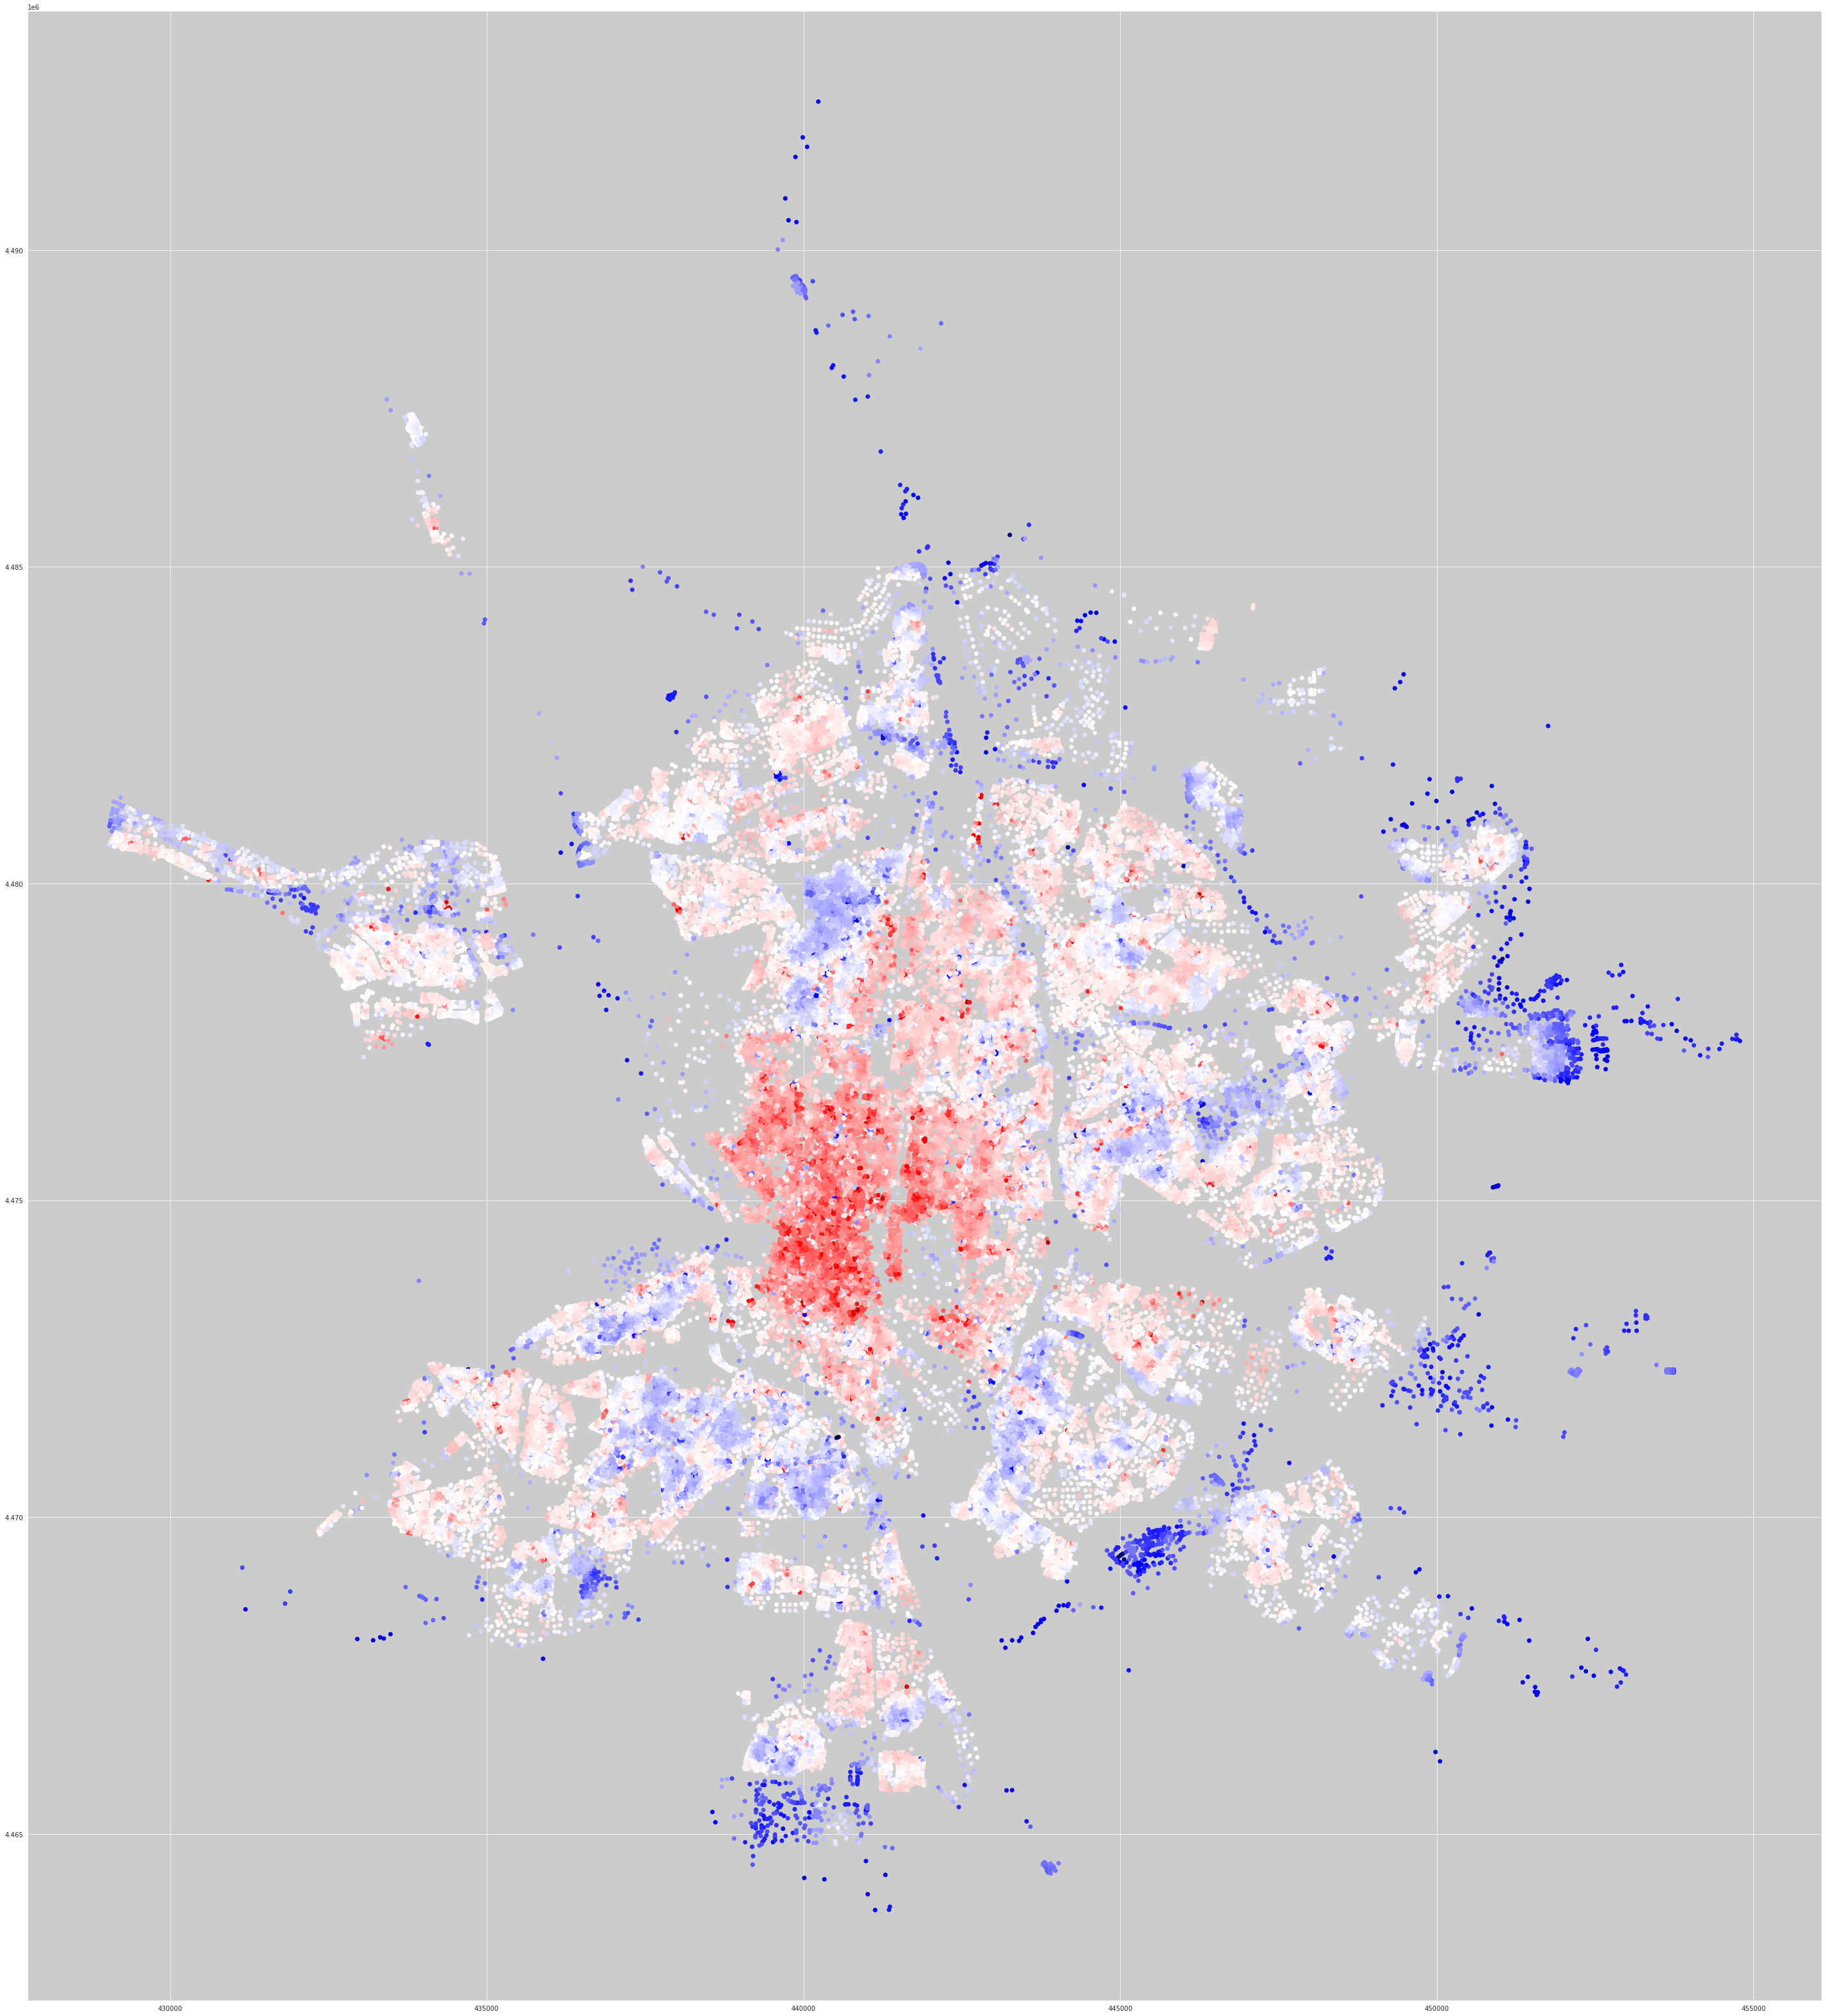

In [14]:
col_to_draw = 'value' # col value corresponds grossfloorarea
build_all_gdf[['geometry', col_to_draw]].plot(figsize = (50,75), column = col_to_draw, cmap = 'seismic')
plt.show()

## MODEL

Checklist:
- Categorical data to convert?
- Missing data to remove?
- Column collinearly - any high correlations?
- Column-wise data distribution - is the distribution skewed?
- Imbalanced data

In [12]:
# CATEGORICAL DATA
# columns that are 'object type'
# ------------------------------
# ID
# conditionOfConstruction
# currentUse
# yearOfConstruction

# NULL DATA 
# 350 nulls in currentUse
# column dm_id_num is pretty much null

In [19]:
# GETTING RID OF NULLS
filtr_01 = build_all_gdf['currentUse'].notnull()
filtr_02 = build_all_gdf['value'].notnull()

build_all_gdf = build_all_gdf.drop(['dm_id_num'], axis = 1)
build_all_gdf = build_all_gdf[filtr_01]
build_all_gdf = build_all_gdf[filtr_02]

print(f"Checking there are no nulls in data: {sum(build_all_gdf.isna().sum().tolist()) == 0}")

Checking there are no nulls in data: True


In [20]:
# TRANSFORM YEAR
## this should be in first or second pipeline for Catastro data
    
build_all_gdf['centuryOfConstr'] = build_all_gdf.apply(lambda x: year_to_halfcentury(x['yearOfConstruction']), axis = 1)
build_all_gdf.drop(['yearOfConstruction'], axis = 1, inplace = True)

In [15]:
## Getting dummies and dropping cols
cat_cols = ['centuryOfConstr', 'currentUse', 'conditionOfConstruction']
cat_df = pd.get_dummies(all_data[cat_cols])
all_data = pd.concat([all_data, cat_df], axis = 1)
all_data.drop(cat_cols, axis = 1, inplace = True)

In [21]:
# ID as index 
# ID is a very useful col but it is categorical
# ID is unique for every urban parcel
# Also, it is not data that is interesting to take into consideration for clustering

build_all_gdf.set_index('ID', inplace = True)

In [22]:
build_all_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 121004 entries, 0003405VK4700C to 9997707VK3899F
Data columns (total 65 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   conditionOfConstruction        121004 non-null  object  
 1   currentUse                     121004 non-null  object  
 2   n_BuildingUnits                121004 non-null  int64   
 3   n_Dwellings                    121004 non-null  int64   
 4   nFloors_AG                     121004 non-null  int64   
 5   nFloors_BG                     121004 non-null  int64   
 6   ID_part                        121004 non-null  int64   
 7   area_m2c                       121004 non-null  int64   
 8   area_m2p                       121004 non-null  int64   
 9   geometry                       121004 non-null  geometry
 10  train                          121004 non-null  float64 
 11  land_use_mix                   121004 non-null  float6

## VISUALIZATION OF DAT

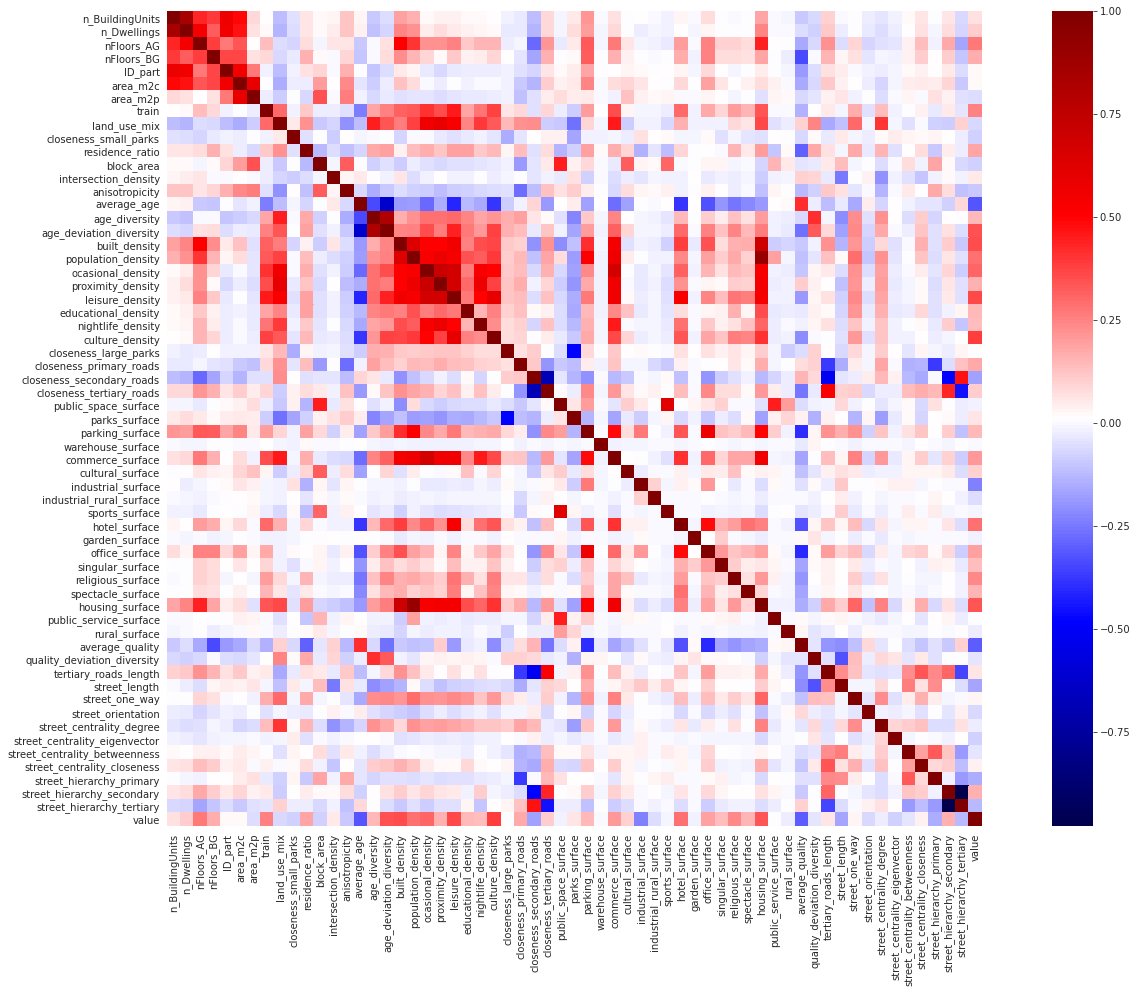

In [25]:
corr_matrix = build_all_gdf.corr()

fig, ax = plt.subplots(figsize = (25, 15))
ax = sns.heatmap(corr_matrix, cmap = 'seismic', square = True)

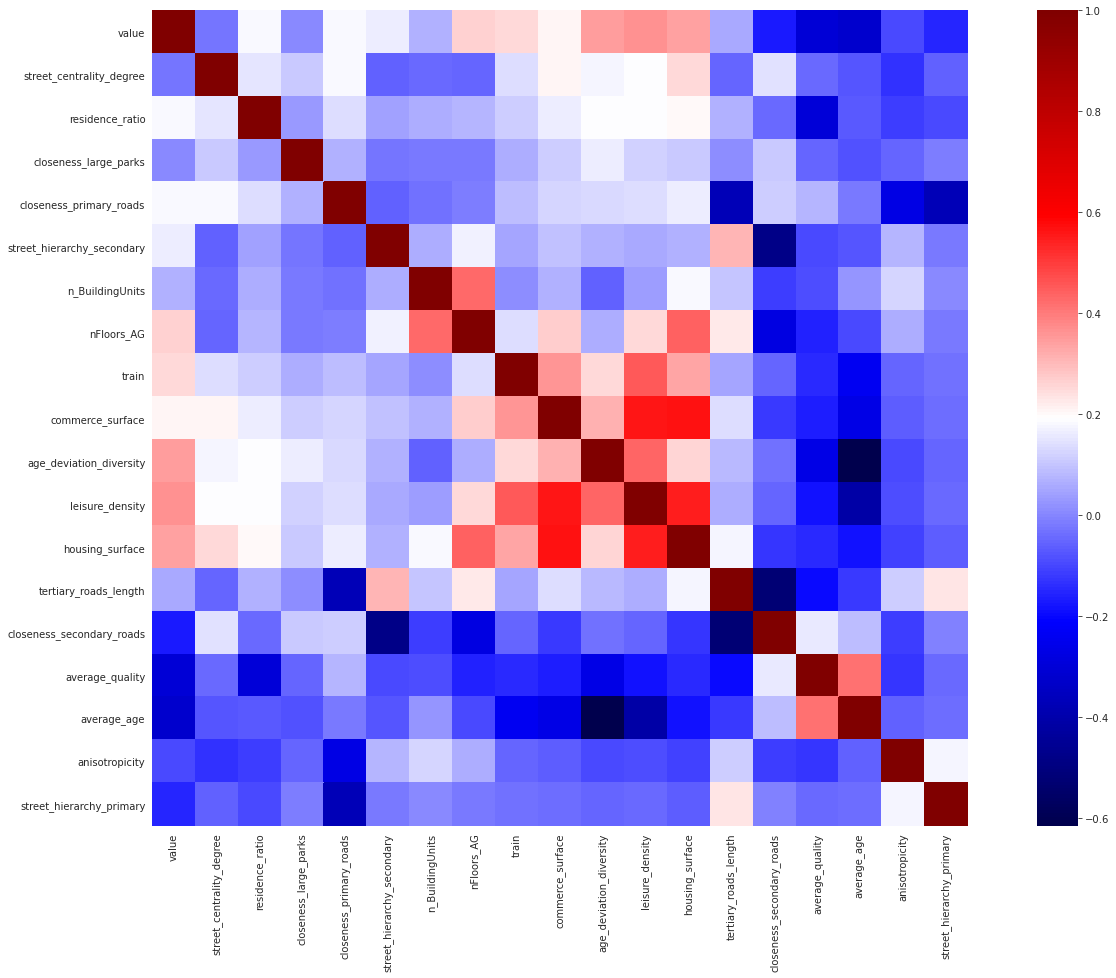

In [26]:
more_important_cols = ['value', 'street_centrality_degree', 'residence_ratio', 'closeness_large_parks', 
                       'closeness_primary_roads', 'street_hierarchy_secondary', 'n_BuildingUnits', 
                       'nFloors_AG', 'train', 'commerce_surface',                     
                       'age_deviation_diversity', 'leisure_density', 'housing_surface', 
                      'tertiary_roads_length',  'closeness_secondary_roads', 'average_quality', 
                       'average_age', 'anisotropicity', 
                       'street_hierarchy_primary']

corr_matrix = build_all_gdf[more_important_cols].corr()

fig, ax = plt.subplots(figsize = (25, 15))
ax = sns.heatmap(corr_matrix, cmap = 'seismic', square = True)

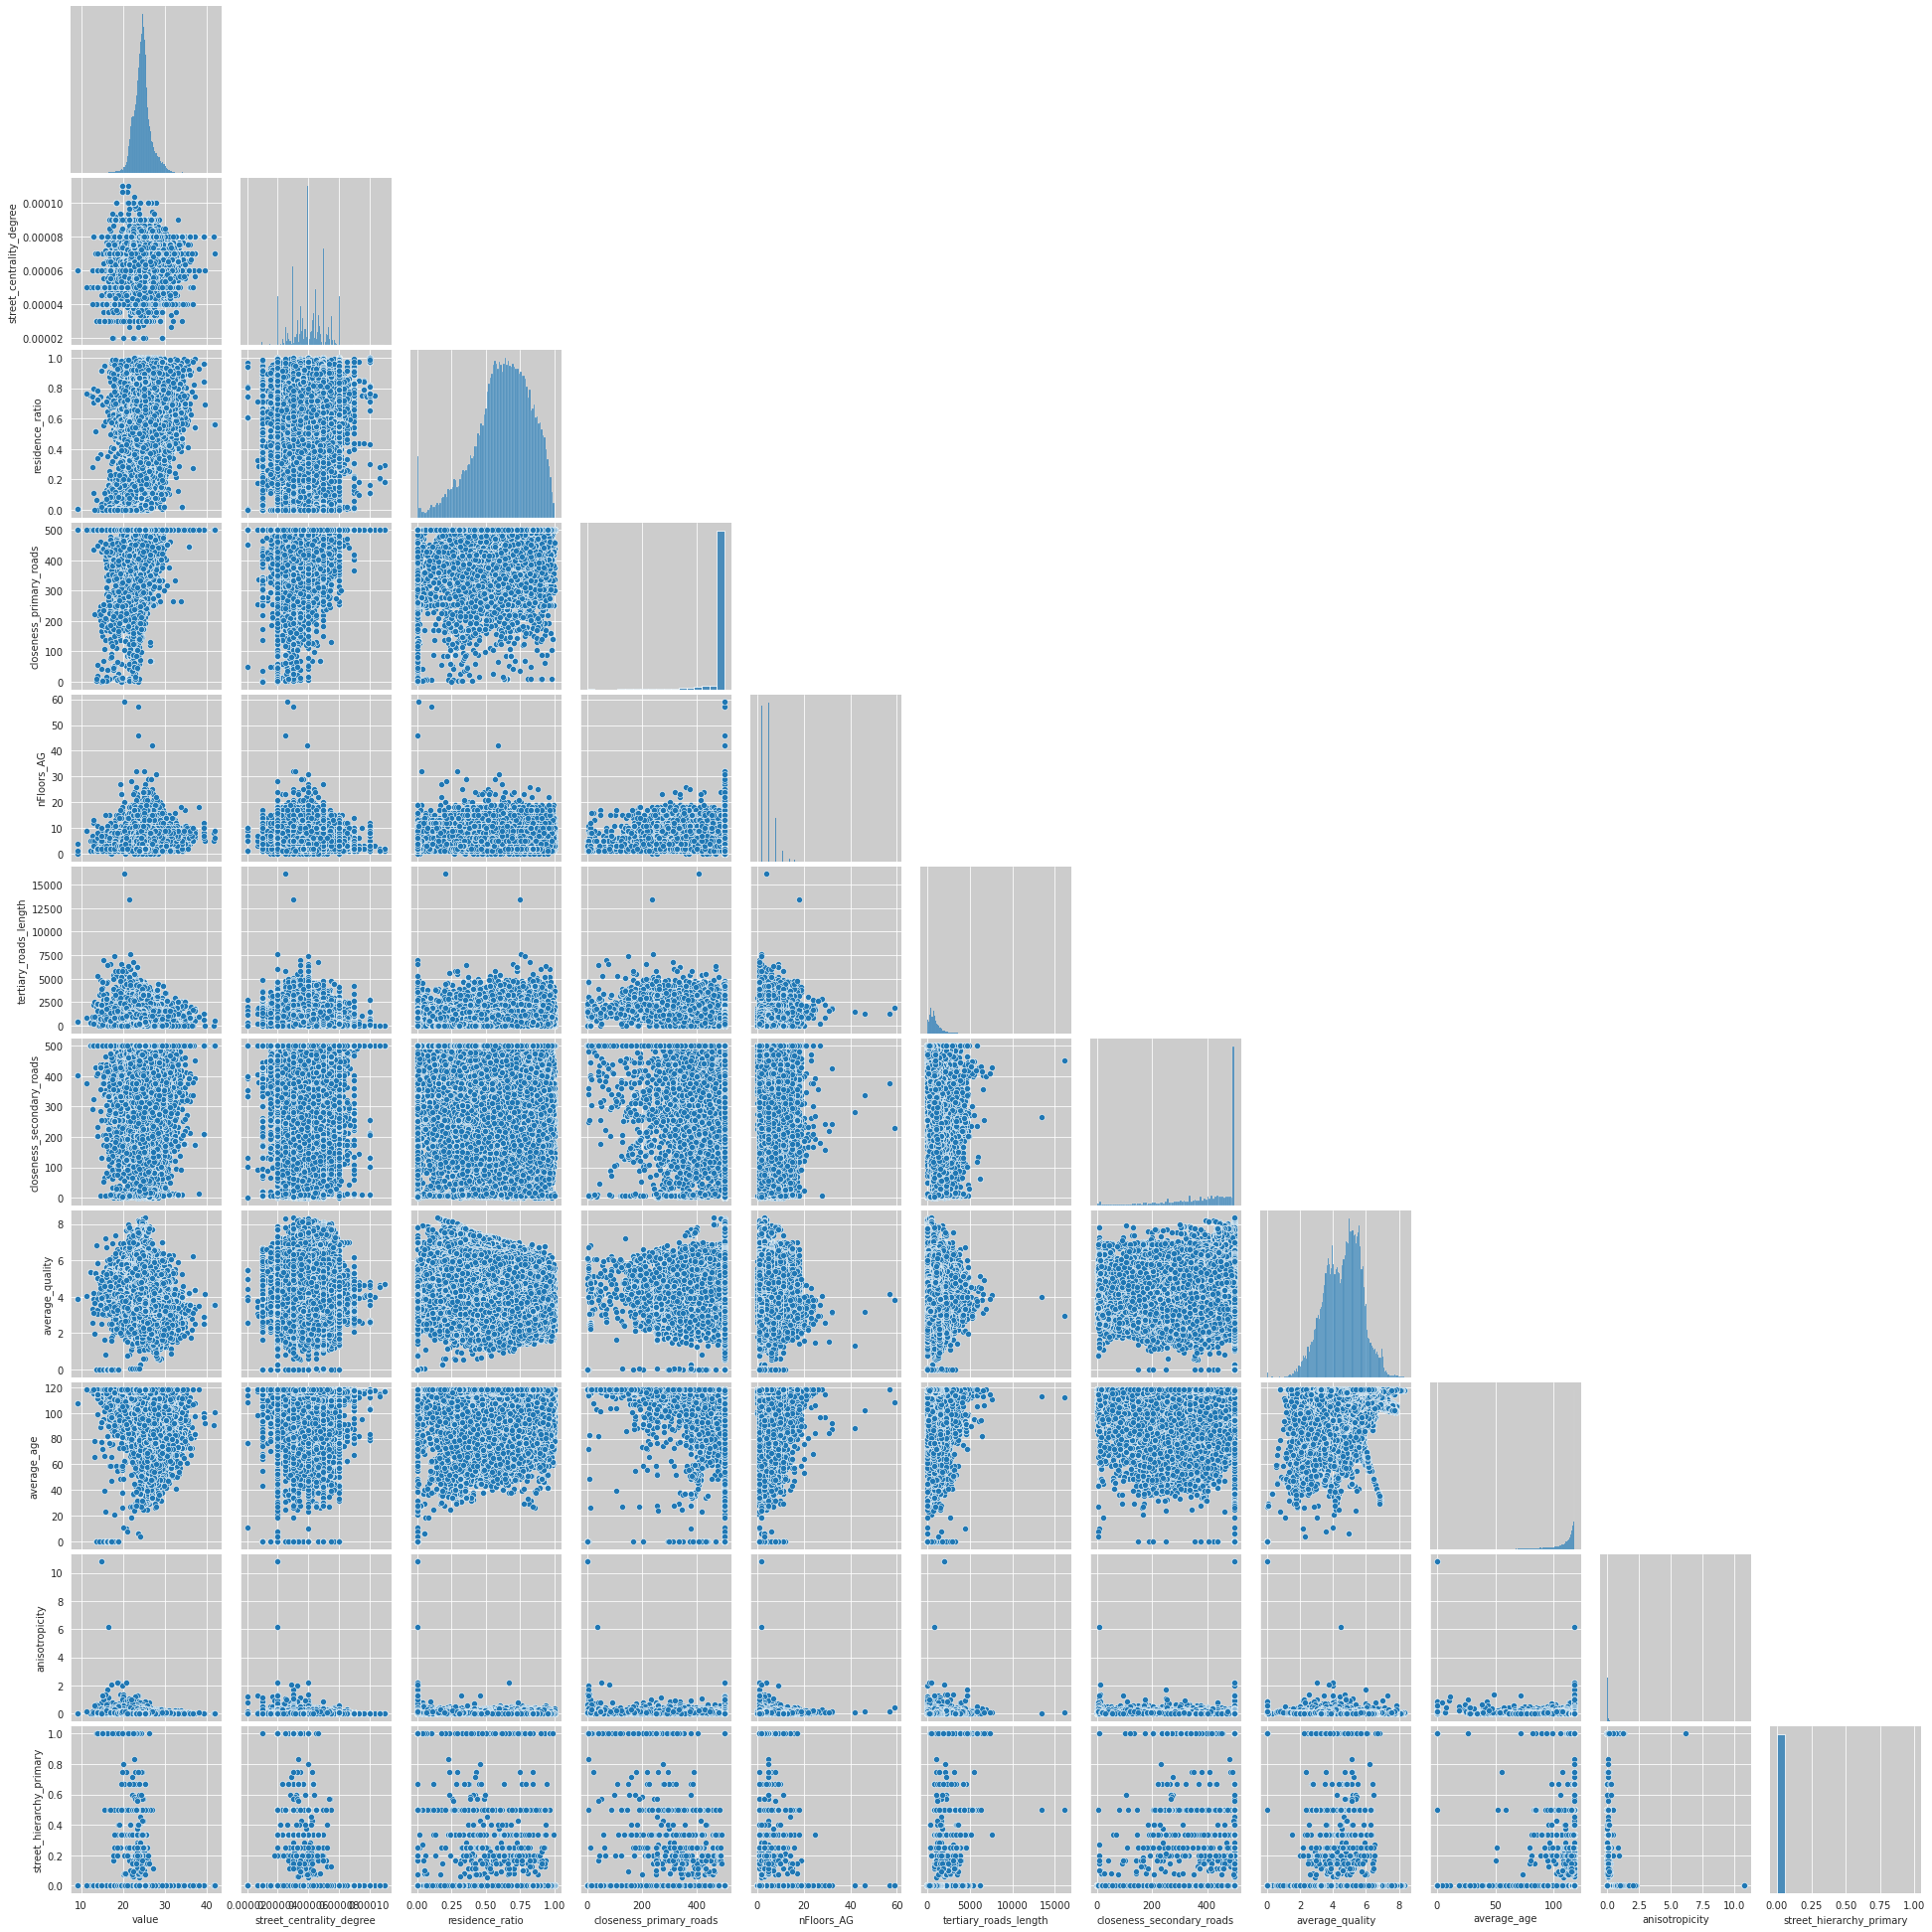

In [147]:
cols_resume = ['value', 'street_centrality_degree', 'residence_ratio', 'closeness_primary_roads', 
               'nFloors_AG', 'tertiary_roads_length', 
               'closeness_secondary_roads', 'average_quality', 'average_age',
               'anisotropicity', 'street_hierarchy_primary']

sns.pairplot(build_all_gdf[cols_resume], corner = True)

plt.show()

In [27]:
build_all_gdf.drop('ID_part', axis = 1, inplace = True)

In [28]:
build_all_gdf[build_all_gdf['value'].isna()]

Empty GeoDataFrame
Columns: [conditionOfConstruction, currentUse, n_BuildingUnits, n_Dwellings, nFloors_AG, nFloors_BG, area_m2c, area_m2p, geometry, train, land_use_mix, closeness_small_parks, residence_ratio, block_area, intersection_density, anisotropicity, average_age, age_diversity, age_deviation_diversity, built_density, population_density, ocasional_density, proximity_density, leisure_density, educational_density, nightlife_density, culture_density, closeness_large_parks, closeness_primary_roads, closeness_secondary_roads, closeness_tertiary_roads, public_space_surface, parks_surface, parking_surface, warehouse_surface, commerce_surface, cultural_surface, industrial_surface, industrial_rural_surface, sports_surface, hotel_surface, garden_surface, office_surface, singular_surface, religious_surface, spectacle_surface, housing_surface, public_service_surface, rural_surface, average_quality, quality_deviation_diversity, tertiary_roads_length, street_length, street_one_way, street_orientation, street_centrality_degree, street_centrality_eigenvector, street_centrality_betweenness, street_centrality_closeness, street_hierarchy_primary, street_hierarchy_secondary, street_hierarchy_tertiary, value, centuryOfConstr]
Index: []

[0 rows x 64 columns]

In [29]:
build_all_gdf.to_file(f"{MODEL_PATH}/all_data.geojson", driver='GeoJSON')